# Consumer Lending Analysis: Lending Club

Data related source:

- https://www.lendingclub.com/info/statistics.action
- https://www.lendingclub.com/developers/listed-loans.action
- http://blog.lendingclub.com/investor-updates-and-enhancements/
- http://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/

Code related source:

- https://github.com/psu4/bad-loan-prediction-lendingclub.com/blob/master/bad-loan-prediction.py#L179
- https://sites.google.com/site/2015pcsu/data-science/predicting-bad-loans-using-lendingclub-com-data
- https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html

## Import data

In [1]:
import pandas as pd
import numpy as np
import dateutil as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statsmodels.api as sm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import graphviz
import xgboost as xgb

%matplotlib inline

# In order to display all the columns, bypass the pandas autodetect
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

C:\Users\rgu\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\rgu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

*All the code below is base on the principle of not changing the raw data.*

**Description of raw data:** 

- Header: specified data source: https://www.lendingclub.com/info/prospectus.action
- Footer: total amount funded in policy code 1 and 2
    - policy_code = 0: rejected
    - policy_code = 1: publicly available
    - policy_code = 2: new products not publicly available
    - currently only policy_code = 1 data open to public
- *desc* is cleared out of 2017 data
- Secondary applicants and co-borrowers information are recorded starting from 2017
- For some of the new credit attributes, we can only see history dating back to March 2012

In [3]:
loan11 = pd.read_csv('LOAN/loan11.csv', header = 1, skipfooter = 2)
loan13 = pd.read_csv('LOAN/loan13.csv', header = 1, skipfooter = 2)
loan14 = pd.read_csv('LOAN/loan14.csv', header = 1, skipfooter = 2)
loan15 = pd.read_csv('LOAN/loan15.csv', header = 1, skipfooter = 2)
loan16q1 = pd.read_csv('LOAN/loan16q1.csv', header = 1, skipfooter = 2)
loan16q2 = pd.read_csv('LOAN/loan16q2.csv', header = 1, skipfooter = 2)
loan16q3 = pd.read_csv('LOAN/loan16q3.csv', header = 1, skipfooter = 2)
loan16q4 = pd.read_csv('LOAN/loan16q4.csv', header = 1, skipfooter = 2)
loan17q1 = pd.read_csv('LOAN/loan17q1.csv', header = 1, skipfooter = 2)
desc = pd.read_csv("DataDictionary.csv", encoding = "ISO-8859-1")

In [4]:
num11 = loan11.describe(include=[np.number]).T
num13 = loan13.describe(include=[np.number]).T
num14 = loan14.describe(include=[np.number]).T
num15 = loan15.describe(include=[np.number]).T
num16q1 = loan16q1.describe(include=[np.number]).T
num16q2 = loan16q2.describe(include=[np.number]).T
num16q3 = loan16q3.describe(include=[np.number]).T
num16q4 = loan16q4.describe(include=[np.number]).T
num17q1 = loan17q1.describe(include=[np.number]).T

cat11 = loan11.describe(include=["O"]).T
cat13 = loan13.describe(include=["O"]).T
cat14 = loan14.describe(include=["O"]).T
cat15 = loan15.describe(include=["O"]).T
cat16q1 = loan16q1.describe(include=["O"]).T
cat16q2 = loan16q2.describe(include=["O"]).T
cat16q3 = loan16q3.describe(include=["O"]).T
cat16q4 = loan16q4.describe(include=["O"]).T
cat17q1 = loan17q1.describe(include=["O"]).T

## Combine data

*pandas.concat* takes a list or dict of homogeneously-typed objects and concatenates them with some configurable handling of “what to do with the other axes”:

- ignore_index : boolean, default False. If True, do not use the index values on the concatenation axis. The resulting axis will be labeled 0, …, n - 1. This is useful if you are concatenating objects where the concatenation axis does not have meaningful indexing information. Note the index values on the other axes are still respected in the join.

In [5]:
Series = [loan11, loan13, loan14, loan15, loan16q1, loan16q2, loan16q3, loan16q4, loan17q1]
fullData = pd.concat(Series, ignore_index = True)
# fullData.to_csv("full.csv")

**Reasonable to delete columns about *secondary applicants* and *co-borrowers*.**

In [6]:
droplist = pd.Series(['sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line',
                      'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
                      'sec_app_revol_util', 'sec_app_open_il_6m', 'sec_app_num_rev_accts',
                      'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog', 
                      'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint'])
fullData = fullData.drop(droplist, 1)

In this project I only use **completed** loans. I saved current paying loans as archive.

In [7]:
Completed = fullData[fullData['loan_status'].isin(["Fully Paid", "Charged Off"])].copy()
Current = fullData[-fullData['loan_status'].isin(["Fully Paid", "Charged Off"])].copy()

In [8]:
pd.Series({"loan11" : len(loan11),
           "loan13" : len(loan13),
           "loan14" : len(loan14),
           "loan15" : len(loan15),
           "loan16q1" : len(loan16q1),
           "loan16q2" : len(loan16q2),
           "loan16q3" : len(loan16q3),
           "loan16q4" : len(loan16q4),
           "loan17q1" : len(loan17q1),
           "[Current]" : len(Current),
           "[Completed]" : len(Completed)
          })

[Completed]    608721
[Current]      809906
loan11          42536
loan13         188181
loan14         235629
loan15         421095
loan16q1       133887
loan16q2        97854
loan16q3        99120
loan16q4       103546
loan17q1        96779
dtype: int64

In [9]:
num = fullData.describe(include=[np.number]).T
num = num[num["count"] <= len(fullData)]
num["MissingRate"] = 100 - num["count"]*100/len(fullData)

cat = fullData.describe(include=["O"]).T
cat = cat[cat["count"] <= len(fullData)]
cat["MissingRate"] = 100 - cat["count"]*100/len(fullData)

In [10]:
cat.sort_values(["MissingRate"], ascending = 0)

,count,unique,top,freq,MissingRate
desc,126068,124502,,252,91.1134
next_pymnt_d,809905,101,Jun-2017,806903,42.9092
emp_title,1331774,398856,Teacher,23533,6.12233
title,1395302,63156,Debt consolidation,703377,1.6442
last_pymnt_d,1417307,114,May-2017,790885,0.0930477
revol_util,1417809,1393,0%,5740,0.0576614
last_credit_pull_d,1418556,119,May-2017,1039307,0.00500484
earliest_cr_line,1418597,721,Aug-2001,10065,0.00211472
zip_code,1418625,949,945xx,15249,0.000140981
url,1418626,1418626,https://lendingclub.com/browse/loanDetail.acti...,1,7.04907e-05


In [11]:
num.sort_values(["MissingRate"], ascending = 0)

,count,mean,std,min,25%,50%,75%,max,MissingRate
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
mths_since_last_record,239082.0,68.966656,26.763876,0.000000e+00,51.00,70.000,88.000000,1.290000e+02,83.146944
mths_since_recent_bc_dlq,342557.0,39.270875,22.741632,0.000000e+00,20.00,37.000,58.000000,1.950000e+02,75.852920
mths_since_last_major_derog,374422.0,44.433433,22.278460,0.000000e+00,27.00,44.000,62.000000,1.970000e+02,73.606734
il_util,479396.0,70.627258,23.295552,0.000000e+00,57.00,74.000,87.000000,1.000000e+03,66.207044
mths_since_recent_revol_delinq,482988.0,35.369539,22.404854,0.000000e+00,16.00,32.000,51.000000,1.970000e+02,65.953841
mths_since_rcnt_il,537642.0,21.327513,26.537362,0.000000e+00,7.00,13.000,24.000000,5.110000e+02,62.101243
all_util,552471.0,59.920609,20.205646,0.000000e+00,47.00,61.000,74.000000,2.040000e+02,61.055936
open_acc_6m,552496.0,0.992355,1.177803,0.000000e+00,0.00,1.000,2.000000,1.800000e+01,61.054174
total_cu_tl,552496.0,1.491993,2.713379,0.000000e+00,0.00,0.000,2.000000,1.110000e+02,61.054174


## Data Cleaning and Manipulation

### 2007 - 2011 Loan CSV file contains 2 datasets (archive)

- Loan data: 39786 records, 14.25% were charged off
- Loans that do not meet the credit policy: 2749 records, 27.68% were charged off
    
Lending Club didn't specify what is the credit policy, but the charge-off rate is significantly higher than normal loans. I decide to delete them.

In [12]:
loan11["loan_status"].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

### Categorical variables

- Delete variables unique to each record such as **url**, **id**.
- Delete data-rich columns such as **emp_title**, **desc**, **title**, **zip_code**. Doing text mining here(later) might offer more valuable results.
- Recategorize variables with too many levels.
- Check misclassified data type such as percentage and datetime.
- Deal with columns with extreme skewness.

In [13]:
Completed.describe(include=["O"]).T

,count,unique,top,freq
id,608721,608721,14680062,1
term,608721,2,36 months,463096
int_rate,608721,569,10.99%,19992
grade,608721,7,B,177019
sub_grade,608721,35,B3,39656
emp_title,573113,235542,Teacher,7508
emp_length,608721,12,10+ years,195126
home_ownership,608721,6,MORTGAGE,303905
verification_status,608721,3,Source Verified,210635
issue_d,608721,118,Oct-2014,22038


In [14]:
Completed["emp_length"].value_counts()

10+ years    195126
2 years       55167
3 years       48661
< 1 year      48576
1 year        39912
5 years       39847
4 years       36569
6 years       31264
7 years       30893
n/a           29465
8 years       29435
9 years       23806
Name: emp_length, dtype: int64

Employment length in months. Possible values are whole numbers from 0 and higher. Null indicates not employed.

In [15]:
Completed["emp_length"] = Completed["emp_length"].str.strip("years")
Completed["emp_length"][Completed["emp_length"]=="10+ "] = 10
Completed["emp_length"][Completed["emp_length"]=="< 1 "] = 1
Completed["emp_length"][Completed["emp_length"]=='n/'] = 0
Completed["emp_length"] = Completed["emp_length"].astype(np.int)
Completed["emp_length"].value_counts()

10    195126
1      88488
2      55167
3      48661
5      39847
4      36569
6      31264
7      30893
0      29465
8      29435
9      23806
Name: emp_length, dtype: int64

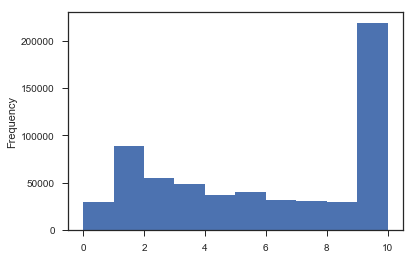

In [16]:
Completed["emp_length"].plot(kind = 'hist')

In [17]:
Completed["home_ownership"].value_counts()

MORTGAGE    303905
RENT        244780
OWN          59825
OTHER          142
NONE            43
ANY             26
Name: home_ownership, dtype: int64

In [18]:
Completed["home_ownership"][Completed["home_ownership"].isin(["RENT", "OTHER", "NONE", "ANY"])] = "RENTorOTHER"
Completed["home_ownership"].value_counts()

MORTGAGE       303905
RENTorOTHER    244991
OWN             59825
Name: home_ownership, dtype: int64

In [19]:
Completed["verification_status"].value_counts()

Source Verified    210635
Verified           209192
Not Verified       188894
Name: verification_status, dtype: int64

In [20]:
Completed["verification_status"][Completed["verification_status"] == "Source Verified"] = "Verified"
Completed["verification_status"].value_counts()

Verified        419827
Not Verified    188894
Name: verification_status, dtype: int64

In [21]:
Completed["int_rate"] = Completed["int_rate"].str.rstrip("%").astype(np.float)
Completed["revol_util"] = Completed["revol_util"].str.rstrip("%").astype(np.float)

| LoanStatNew        | Description                                                       |
|--------------------|-------------------------------------------------------------------|
| earliest_cr_line   | The month the borrower's earliest reported credit line was opened |
| issue_d            | The month which the loan was funded                               |
| last_credit_pull_d | The most recent month LC pulled credit for this loan              |
| last_pymnt_d       | Last month payment was received                                   |
| next_pymnt_d       | Next scheduled payment date                                       |

- *pandas.to_datetime* convert argument to datetime.

- *strptime* parse a string representing a time according to a format.

- *strftime* convert a tuple or struct_time representing a time to a **string** as specified by the format argument.

In [22]:
TimeColumn = pd.Series(['issue_d', 'last_pymnt_d', 'earliest_cr_line'])

# Completed[TimeColumn] = pd.PeriodIndex(pd.to_datetime(Completed[TimeColumn]), freq='M')
Completed[TimeColumn] = Completed[TimeColumn].apply(pd.to_datetime)

# Completed["next_pymnt_d"] = pd.PeriodIndex(Completed["next_pymnt_d"], freq='M')
# Completed["last_credit_pull_d"] = pd.PeriodIndex(Completed["last_credit_pull_d"], freq='M')
Completed["earliest_cr_line"] = pd.PeriodIndex(Completed["earliest_cr_line"], freq='M')
Completed["issue_d"] = pd.PeriodIndex(Completed["issue_d"], freq='M')
Completed["last_pymnt_d"] = pd.PeriodIndex(Completed["last_pymnt_d"], freq='M')

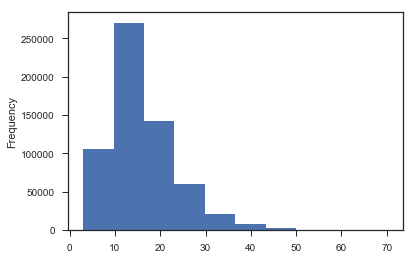

In [23]:
Completed["credit_history"] = Completed["issue_d"] - Completed["earliest_cr_line"]
Completed["credit_history"] = Completed["credit_history"].astype(np.int16)
(Completed["credit_history"]/12).plot(kind = "hist")

In [24]:
# Completed["loan_month"] = (Completed["last_pymnt_d"] - Completed["issue_d"])/ np.timedelta64(1, 'M')
# Completed["loan_month"] = (Completed["last_pymnt_d"].dt.year - Completed["issue_d"].dt.year) * 12 + 
#                          (Completed["last_pymnt_d"].dt.month - Completed["issue_d"].dt.month) + 1
# or why not just use days instead of months?
# - No, cause we are gonna compare this to "term" later, which is 36/60 month.

Completed["loan_month"] = Completed["last_pymnt_d"] - Completed["issue_d"]
# Completed["loan_month"] = Completed["loan_month"].astype(np.int16)

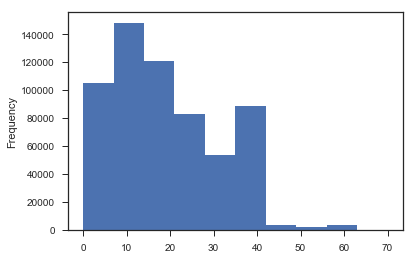

In [25]:
Completed["loan_month"].dropna().plot(kind = "hist")

In [26]:
print(Completed["pymnt_plan"].value_counts())
print("--------------------------------------------------------")
print(Completed["application_type"].value_counts())

n    608721
Name: pymnt_plan, dtype: int64
--------------------------------------------------------
INDIVIDUAL    606863
JOINT           1206
DIRECT_PAY       652
Name: application_type, dtype: int64


*initial_list_status*: LC announced that whole loans would be chosen randomly from the general pool, which means the variable should not effect the final status of the loan.

In [27]:
droplist = pd.Series(["id", "url", "emp_title", "desc", "title", "zip_code", 
                      "pymnt_plan", "application_type", "initial_list_status",
                      "next_pymnt_d", "last_pymnt_d", "earliest_cr_line", "last_credit_pull_d", "issue_d"])
Completed = Completed.drop(droplist, 1)

In [28]:
Completed.describe(include=["O"]).T

,count,unique,top,freq
term,608721,2,36 months,463096
grade,608721,7,B,177019
sub_grade,608721,35,B3,39656
home_ownership,608721,3,MORTGAGE,303905
verification_status,608721,2,Verified,419827
loan_status,608721,2,Fully Paid,485425
purpose,608721,14,debt_consolidation,360003
addr_state,608721,51,CA,95117
loan_month,607543,70,36,59006


### Numerical variables

- Delete columns MissingRate > 5%

    <span style="color:gray">Reference: The proportion of missing data is directly related to the quality of statistical inferences. Yet, there is no established cutoff from the literature regarding an acceptable percentage of missing data in a data set for valid statistical inferences. For example, Schafer ( 1999 ) asserted that a missing rate of</span> **5%** <span style="color:gray">or less is inconsequential. Bennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than</span> **10%** <span style="color:gray">of data are missing. Furthermore, the amount of missing data is not the sole criterion by which a researcher assesses the missing data problem. Tabachnick and Fidell ( 2012 ) posited that the missing data mechanisms and the missing data patterns have greater impact on research results than does the proportion of missing data. </span>
    
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/
    

- Create new variables.
- Deal with columns with too much missing data.
- Deal with columns with extreme skewness.

In [29]:
describe_numerical = Completed.describe(include=[np.number]).T
numClean = describe_numerical[describe_numerical["count"] <= len(Completed)]
numClean["MissingRate"] = 100 - numClean["count"]*100/len(Completed)
numClean.sort_values(["MissingRate"], ascending = 0)

,count,mean,std,min,25%,50%,75%,max,MissingRate
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
il_util,69189.0,73.493532,21.732831,0.00,62.00,77.000000,89.000000,2.500000e+02,88.633709
mths_since_rcnt_il,77568.0,17.909499,23.738312,0.00,6.00,10.000000,19.000000,3.380000e+02,87.257216
all_util,79287.0,59.168678,20.841522,0.00,46.00,61.000000,74.000000,1.620000e+02,86.974821
open_acc_6m,79290.0,1.195321,1.308662,0.00,0.00,1.000000,2.000000,1.700000e+01,86.974328
inq_last_12m,79290.0,2.568458,2.720160,0.00,1.00,2.000000,4.000000,3.200000e+01,86.974328
total_cu_tl,79290.0,1.815387,3.055515,0.00,0.00,1.000000,2.000000,4.500000e+01,86.974328
inq_fi,79291.0,1.155465,1.674339,0.00,0.00,1.000000,2.000000,2.800000e+01,86.974164
max_bal_bc,79291.0,5609.477280,5456.308169,0.00,2145.00,4217.000000,7326.500000,2.500000e+05,86.974164
open_rv_24m,79291.0,3.223821,2.795960,0.00,1.00,3.000000,4.000000,4.500000e+01,86.974164


*DataFrame.dropna* return object with labels on given axis omitted where alternately any or all of the data are missing:

- thresh: keeps only rows/columns with at least *thresh* non-na values.

- how : 
    - any : if any NA values are present, drop that label
    - all : if all values are NA, drop that label
    
- axis : 
    - 0 : index
    - 1 : columns
    
*numpy.setdiff1d*: find the set difference of two arrays ar1 and ar2. Return the sorted, unique values in ar1 that are not in ar2.

In [30]:
# Another function to drop NAs
# Completed = Completed.dropna(axis = 1, thresh = 0.05 * Completed.shape[0])
# np.setdiff1d(variable1, variable2)

droplist = numClean[numClean["MissingRate"] > 5].index
Completed = Completed.drop(droplist, 1)

In [31]:
numClean[numClean["MissingRate"] > 5].index

Index(['member_id', 'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr

In [32]:
Completed["avg_fico"] = Completed[["fico_range_high", "fico_range_low"]].mean(axis = 1)

Delete *last fico range*: 

Reasonable to assume that if a loan is charged off, fico score of the borrower would go down accordingly. Thus we cannot use *last fico range* as predictor, it's like using the result to predict the result.

In [33]:
# Completed["last_fico"] = Completed[["last_fico_range_high", "last_fico_range_low"]].mean(axis = 1)
# Completed["fico_change"] = Completed["last_fico"] - Completed["avg_fico"]
Completed = Completed.drop(["fico_range_high", "fico_range_low", "last_fico_range_high", "last_fico_range_low"], 1)

### Skewness of independent variable

- Solution1: Delete columns with extreme skewness. Will try to manipulate these columns later. Maybe use dummy variables to recategorize them.
- **Solution2**: Fit in RandomForest model and filter out the unimportant variables.

In [34]:
# NOT OK! NOT OK! NOT OK! ###################################################
#                                                                           #
#  skewness = dataClean.isnull().skew()                                     #
#  skewness[skewness.index[skewness > 10]].sort_values(ascending = False)   #
#  dataClean = dataClean.drop(skewness.index[skewness > 10], 1)             #
#                                                                           #
#############################################################################

skew_desc = Completed.describe(include=[np.number]).T
skew_desc[skew_desc["75%"]==0]

# pd.pivot_table(Completed, index=["delinq_2yrs"], columns=["loan_status"], aggfunc="count", values="id").fillna(0)

,count,mean,std,min,25%,50%,75%,max
delinq_2yrs,608721.0,0.293000,0.827286,0.0,0.0,0.0,0.0,39.00
pub_rec,608721.0,0.190365,0.558042,0.0,0.0,0.0,0.0,86.00
out_prncp,608721.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
out_prncp_inv,608721.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
total_rec_late_fee,608721.0,0.888627,6.572717,0.0,0.0,0.0,0.0,367.60
recoveries,608721.0,189.895231,809.564894,0.0,0.0,0.0,0.0,39444.37
collection_recovery_fee,608721.0,28.415331,135.979167,0.0,0.0,0.0,0.0,7002.19
collections_12_mths_ex_med,608665.0,0.012332,0.123287,0.0,0.0,0.0,0.0,16.00
acc_now_delinq,608721.0,0.004574,0.072768,0.0,0.0,0.0,0.0,6.00
chargeoff_within_12_mths,608665.0,0.008175,0.102729,0.0,0.0,0.0,0.0,7.00


In [35]:
# droplist = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']
# Completed = Completed.drop(droplist, 1)

However the importance of *delinq_2yrs* and *pub_rec_bankruptcies* is negligible (shown in *Random Forest table of importance*), let's try some data transformation.

### Other variables need to be deleted

- **Post-approval** variables are removed. They should not be used for bad loans prediction.
- Columns that are very correlated are removed.

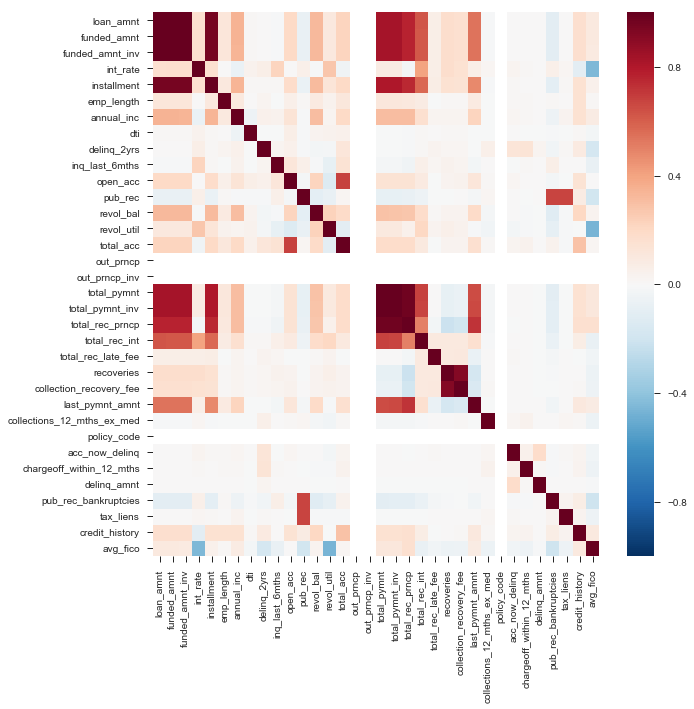

In [36]:
corr = Completed.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# corr[list(Completed)[3]][corr[list(Completed)[3]]>0.9]
# corr["tot_cur_bal"][corr["tot_cur_bal"]>0.5]

In [37]:
droplist = pd.Series(["policy_code",                                       # all 1
                      "int_rate",                                          # different in different time period
                      "funded_amnt", "funded_amnt_inv", "installment",     # loan_amnt                  
                      "last_pymnt_amnt", "total_pymnt", "total_rec_int",   # post-approval variables
                      "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp",
                      "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"
                     ])
Completed = Completed.drop(droplist, 1)

#### Deal with missing data

- Delete rows that have more than 2 missing columns
- Fill with either 0 or average value

In [38]:
Completed.describe(include=[np.number]).T.sort_values("count")

,count,mean,std,min,25%,50%,75%,max
pub_rec_bankruptcies,608024.0,0.126316,0.365499,0.0,0.00,0.00,0.00,8.0
revol_util,608350.0,53.498771,24.381448,0.0,35.50,54.40,72.50,892.3
chargeoff_within_12_mths,608665.0,0.008175,0.102729,0.0,0.00,0.00,0.00,7.0
collections_12_mths_ex_med,608665.0,0.012332,0.123287,0.0,0.00,0.00,0.00,16.0
tax_liens,608682.0,0.039444,0.355243,0.0,0.00,0.00,0.00,85.0
inq_last_6mths,608720.0,0.756349,1.012346,0.0,0.00,0.00,1.00,8.0
delinq_amnt,608721.0,12.138080,677.596729,0.0,0.00,0.00,0.00,88216.0
acc_now_delinq,608721.0,0.004574,0.072768,0.0,0.00,0.00,0.00,6.0
total_acc,608721.0,25.444156,11.920473,2.0,17.00,24.00,32.00,176.0
loan_amnt,608721.0,14209.031929,8414.304441,500.0,8000.00,12000.00,20000.00,40000.0


In [39]:
Completed = Completed.dropna(axis = 0, thresh = Completed.shape[1] - 2)

In [40]:
Completed["revol_util"] = Completed["revol_util"].fillna(Completed["revol_util"].mean())
Completed = Completed.fillna(0)

### Response variable: loan_status

- 1: Loans fully paid
- 0: Loans charged off, late, in grace period
- others: Loans I'll use later for the implementation/prediction part of the model

*"Does not meet the credit policy."* only in 2015 dataset.

In [41]:
Completed["loan_status"].value_counts()

Fully Paid     485376
Charged Off    123291
Name: loan_status, dtype: int64

### Another loan status indicator: loan_month

loan_month = Last Payment Date - Issue Date

#### Delete: loans never get paid

last_pymnt_d = NaN: 1319 loans

loan_status is one of the below. We may consider these loans as default or **drop** them cause they never get paid.

#### Question: loans longer than payment term but still paying, delete or not??

There are about 20K in 600K loans.

Although they are longer than *term*, only 121 are charged off. Do we really need to delete them?

In [42]:
longer_36 = Completed.query("term == ' 36 months' & loan_month > 36")
longer_60 = Completed.query("term == ' 60 months' & loan_month > 60")
longer = longer_36.append(longer_60)
longer["loan_status"].value_counts()

Fully Paid     20169
Charged Off      121
Name: loan_status, dtype: int64

- Fully Paid:     80529
- Current:          941
- Charged Off:      349

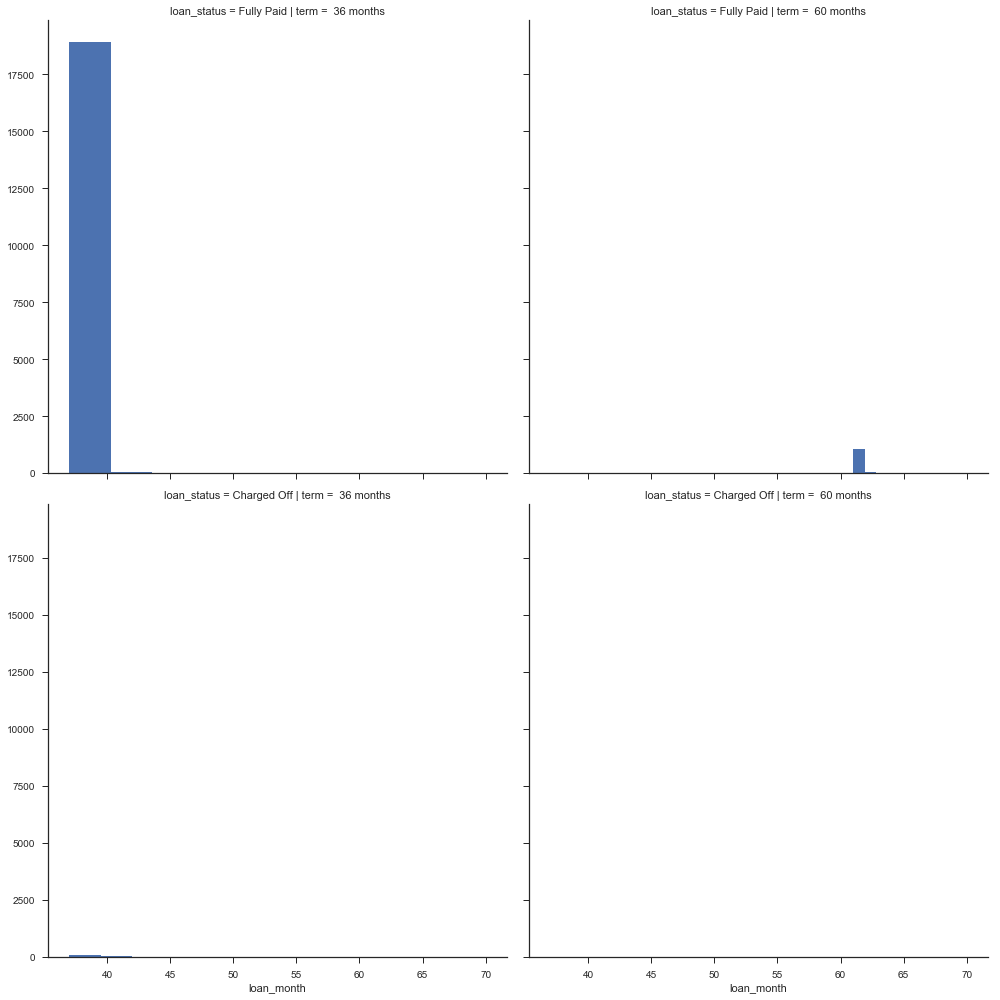

In [43]:
g = sns.FacetGrid(longer, col = "term", row = "loan_status", size = 7)
g = g.map(plt.hist, "loan_month")

### Create Dummy vatiables for categorical variables

Only consider levels < 10

- term
- grade
- home_ownership
- verification_status

Actually XGBoost can deal with sparse matrix so I will create more dummys later.

In [44]:
term = pd.get_dummies(Completed["term"])
grade = pd.get_dummies(Completed["grade"])
home_ownership = pd.get_dummies(Completed["home_ownership"])
verification_status = pd.get_dummies(Completed["verification_status"])

In [45]:
Completed = pd.concat([Completed, term, grade, home_ownership, verification_status], axis = 1)
Completed = Completed.drop(["term", "grade", "home_ownership", "verification_status"], 1)

## Model selection

### Split 3/7 training/testing

Kept all numerical variables to run a rough model. Sklearn needs all categorical variables to be transformed into dummys.

In [46]:
positive = ['Fully Paid']
negative = ['Charged Off']

Completed['loan_status'] = Completed['loan_status'].isin(positive).astype(int)

In [47]:
cols_to_keep = ['loan_status', 'loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
                'open_acc', 'total_acc', 'pub_rec', 'revol_bal', 'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq',
                'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'credit_history',
                'avg_fico', ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'MORTGAGE', 'OWN', 'RENTorOTHER',
                'Not Verified', 'Verified']

ml_df = Completed[cols_to_keep]
train_cols = ml_df.columns[1:]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(ml_df[train_cols], ml_df['loan_status'], test_size = 0.3, random_state = 1)

### Logistic Regression

In [49]:
logit = sm.Logit(y_train, X_train)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.459494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               426066
Model:                          Logit   Df Residuals:                   426036
Method:                           MLE   Df Model:                           29
Date:                Wed, 02 Aug 2017   Pseudo R-squ.:                 0.08926
Time:                        11:29:09   Log-Likelihood:            -1.9577e+05
converged:                       True   LL-Null:                   -2.1496e+05
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                  -1.197e-05   6.27e-07    -19.077      0.000   -1.32e-05   -1.07e-05
emp_length                     0.0157      0.001     13.969      0.000       0.013       0.018
annual_inc                  2.945e-06   1.32e-07     22.361      0.000    2.69e-06     3.2e-06
dti                           -0.0179      0.001    -32.005      0.000      -0.019      -0.017
delinq_2yrs                   -0.0315      0.005     -6.551      0.000      -0.041      -0.022
inq_last_6mths                -0.0642      0.004    -16.038      0.000      -0.072      -0.056
open_acc                      -0.0254      0.001    -23.040      0.000      -0.028      -0.023
total_acc                      0.0127      0.001     24.937      0.000       0.012       0.014
pub_rec                       -0.0723      0.019     -3.742      0.000      -0.110      -0.034
revol_bal                   2.667e-06   2.97e-07      8.991      0.000    2.09e-06    3.25e-06
revol_util                    -0.0006      0.000     -2.751      0.006      -0.001      -0.000
collections_12_mths_ex_med    -0.2033      0.029     -7.130      0.000      -0.259      -0.147
acc_now_delinq                 0.0135      0.052      0.257      0.797      -0.089       0.116
chargeoff_within_12_mths       0.0444      0.038      1.157      0.247      -0.031       0.120
delinq_amnt                 -9.55e-06    5.2e-06     -1.836      0.066   -1.97e-05    6.46e-07
pub_rec_bankruptcies           0.1063      0.022      4.840      0.000       0.063       0.149
tax_liens                      0.0319      0.022      1.442      0.149      -0.011       0.075
credit_history                -0.0004   5.08e-05     -7.953      0.000      -0.001      -0.000
avg_fico                       0.0061      0.000     30.751      0.000       0.006       0.007
 36 months                     2.6159   1.11e+05   2.37e-05      1.000   -2.17e+05    2.17e+05
 60 months                     2.1014   1.08e+05   1.94e-05      1.000   -2.12e+05    2.12e+05
A                             -2.6440   4.71e+05  -5.61e-06      1.000   -9.24e+05    9.24e+05
B                             -3.0695   4.66e+05  -6.58e-06      1.000   -9.14e+05    9.14e+05
C                             -3.4891    4.7e+05  -7.43e-06      1.000   -9.21e+05    9.21e+05
D                             -3.7630   4.76e+05  -7.91e-06      1.000   -9.32e+05    9.32e+05
E                             -3.9498   4.62e+05  -8.55e-06      1.000   -9.06e+05    9.06e+05
F                             -4.1002   4.68e+05  -8.75e-06      1.000   -9.18e+05    9.18e+05
G                             -4.2301   4.64e+05  -9.12e-06      1.000   -9.09e+05    9.09e+05
MORTGAGE                      -0.4926   1.96e+05  -2.51e-06      1.000   -3.85e+05    3.85e+05
OWN                           -0.6654      2e+05  -3.32e-06      1.000   -3.92e+05    3.92e+05
RENTorOTHER                   -0.7832   2.04e+05  -3.84e-06      1.000      -4e+05       4e+05
Not Verifie

In [50]:
lr_pred = result.predict(X_test)
fpr, tpr, thresholds =roc_curve(y_test, lr_pred)

#  Area Under the Curve
roc_auc = auc(fpr, tpr)

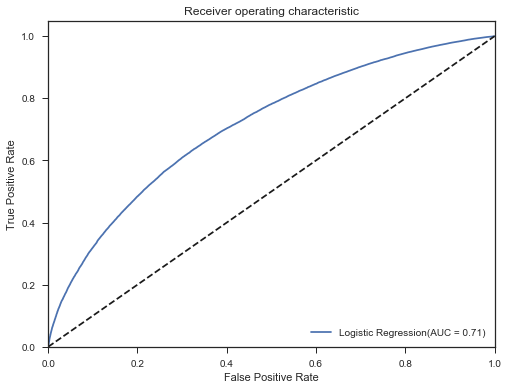

In [51]:
plt.figure(figsize = (8, 6))
plt.plot(fpr,tpr,label='Logistic Regression(AUC = %0.2f)' % roc_auc)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [52]:
rf = RandomForestClassifier()
rf_result = rf.fit(X_train, y_train)
rf_pred = rf_result.predict(X_test)
fpr2, tpr2, thresholds2 = roc_curve(y_test, rf_pred)
roc_auc2 = auc(fpr2,tpr2)

In [53]:
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index = train_cols, columns = ["Importance"])
importance.sort_values("Importance")

,Importance
acc_now_delinq,0.000928
delinq_amnt,0.001057
G,0.001667
chargeoff_within_12_mths,0.001691
collections_12_mths_ex_med,0.002904
F,0.003903
tax_liens,0.004179
OWN,0.004538
Verified,0.005396
C,0.005816


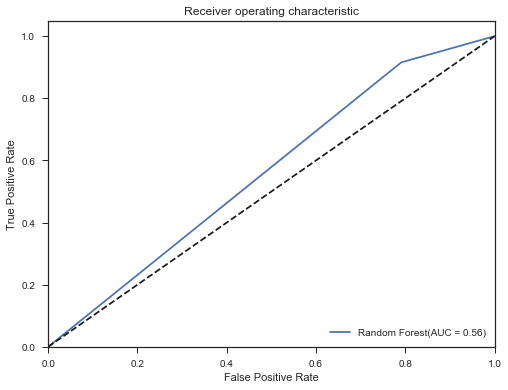

In [54]:
plt.figure(figsize = (8, 6))
plt.plot(fpr2,tpr2,label='Random Forest(AUC = %0.2f)' % roc_auc2)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### KNN

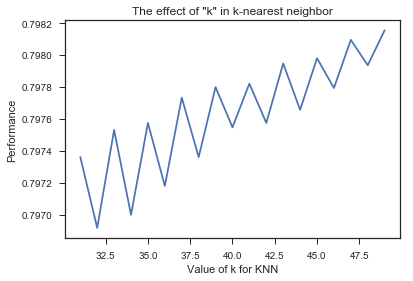

In [55]:
# best K

k_range = range(31,50)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_result = knn.fit(X_train,y_train)
    knn_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, knn_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Performance')
plt.title('The effect of "k" in k-nearest neighbor')

In [56]:
knn = KNeighborsClassifier()
knn_result = knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
fpr3, tpr3, thresholds3 =roc_curve(y_test, knn_pred)
roc_auc3 = auc(fpr3, tpr3)

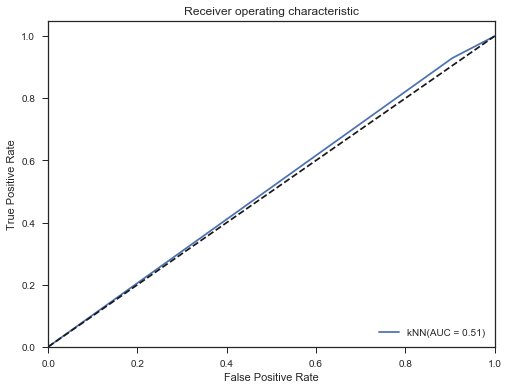

In [57]:
plt.figure(figsize = (8, 6))
plt.plot(fpr3,tpr3,label='kNN(AUC = %0.2f)' % roc_auc3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [58]:
clf = svm.LinearSVC(dual = False, C = 100)
clf_result = clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
fpr4, tpr4, thresholds4 = roc_curve(y_test, clf_pred)
roc_auc4 = auc(fpr4, tpr4)

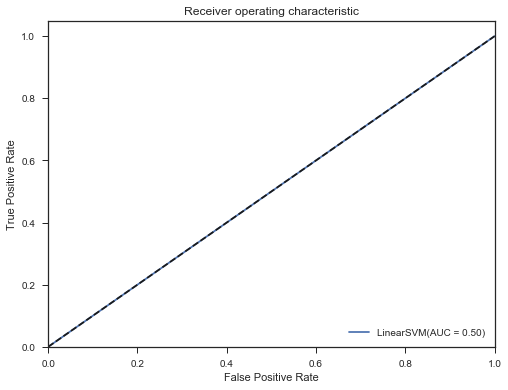

In [59]:
plt.figure(figsize = (8, 6))
plt.plot(fpr4,tpr4,label='LinearSVM(AUC = %0.2f)' % roc_auc4)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [60]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [61]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
plst = param.items()

evallist  = [(dtest,'eval'), (dtrain,'train')]

In [62]:
num_round = 100
bst = xgb.train(plst, dtrain, num_round)

In [63]:
ypred = bst.predict(dtest)

In [64]:
fpr5, tpr5, thresholds5 = roc_curve(y_test, ypred)
roc_auc5 = auc(fpr5, tpr5)

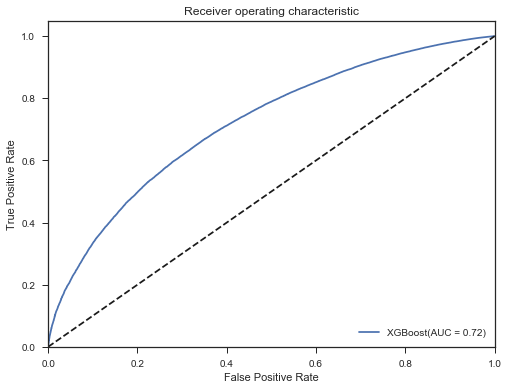

In [65]:
plt.figure(figsize = (8, 6))
plt.plot(fpr5,tpr5,label='XGBoost(AUC = %0.2f)' % roc_auc5)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

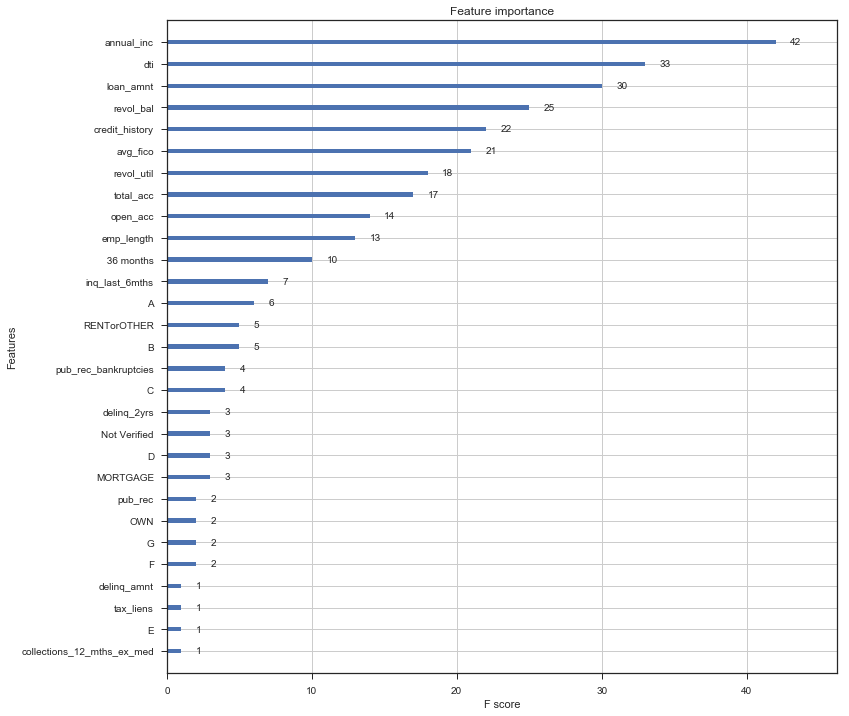

In [66]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(bst, ax = ax)

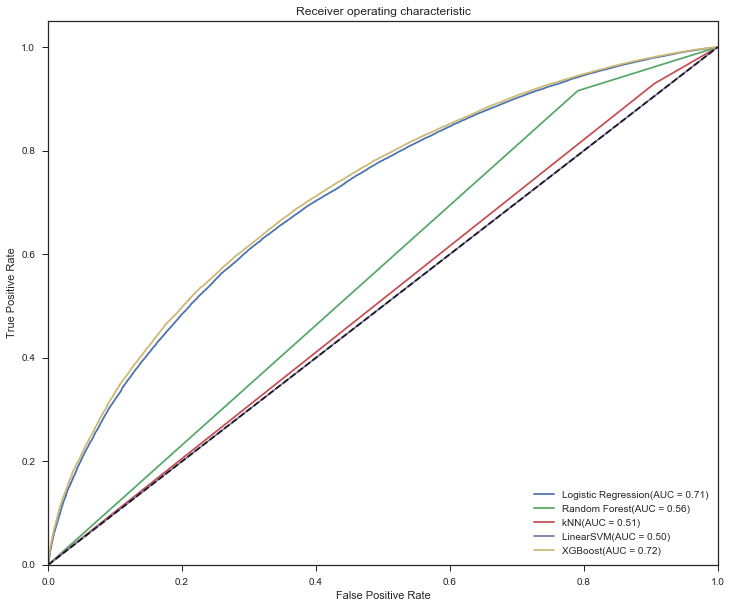

In [67]:
plt.figure(figsize = (12, 10))
plt.plot(fpr,tpr,label='Logistic Regression(AUC = %0.2f)' % roc_auc)
plt.plot(fpr2,tpr2,label='Random Forest(AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3,tpr3,label='kNN(AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4,tpr4,label='LinearSVM(AUC = %0.2f)' % roc_auc4)
plt.plot(fpr5,tpr5,label='XGBoost(AUC = %0.2f)' % roc_auc5)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()